This notebook show the procedure of fitting a gaussian distribution with MCMC.

Given the mean $\mu$ and std $\sigma$, the likelihood of observing $x$ is 

$$ P\left(x|\mu,\sigma \right)= \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{\left(x-\mu\right)^2}{2\sigma^2} \right)$$


If you have many $x$s, simply multiply them. In practice, better use log form. The log of likelihood is 

$$ \log P\left(x|\mu,\sigma \right)= -0.5*\log\left(2\pi\right)-\log\left(\sigma\right)  -\frac{\left(x-\mu\right)^2}{2\sigma^2}  $$

In [68]:
#simulate gaussian data
np.random.seed()

mu_sim=20,
std_sim=5,
####### 
simData=np.random.normal(mu_sim,std_sim,2000)

In [69]:
#assmuing we do not inow mu_sim and std_sim.

def getlogp(data,mu,istd):
    logp=-0.5*np.log(2*np.pi)+0.5*np.log(istd**2)-(data-mu)**2/2.*istd**2
    
    return np.sum(logp)


In [70]:
getlogp(simData,1,3)

-3464322.0730174733

In [88]:
#the MCMC part

mu0=np.random.exponential(2)
istd0=np.random.exponential(1)

P0=getlogp(simData,mu0,istd0)

muList= [mu0]
istdList=[ istd0]

 
for i in range(20000):
    muCand=muList[-1]+np.random.normal(0,3)

    istdCand=istdList[-1]+np.random.normal(0,1)
    
    if istdCand<0: #we only want positive values
        continue
    
    P1=getlogp(simData,muCand,istdCand)
    
    u=np.random.uniform(0,1)

    if P1>P0 or P1-P0>np.log(u):
        #accept
        P0=P1
        print muCand,1./istdCand,i
        muList.append(muCand)
        istdList.append(istdCand)
    else:
        #rect
        #continue
        muList.append(muList[-1])
        istdList.append(istdList[-1])
burn_in=1000
goodMu=np.array(muList[burn_in:])
istdList=1./np.array(istdList[burn_in:])

print len(muList)
print "Done"

-2.07465281182 13.166454101 1
-2.27186564125 37.88640401 43
-5.42153241429 23.5530951117 110
-4.60153562785 26.9780286976 296
1.70867283777 26.8554359413 305
4.70617556402 11.7853155079 584
8.92086935698 15.0984465305 586
9.52686896189 11.8161184272 621
13.6898060446 7.92796590852 628
17.7197075207 5.14361684355 668
20.3799586514 3.97809447354 674
19.2276232345 4.23616856891 678
19.934162394 5.57317752583 715
20.5579181205 5.04843441645 718
20.5043061437 4.86164375398 1251
20.0561016776 4.91584104547 1832
19.958435821 4.78924078897 4057
19.9982198007 5.0646055232 5773
19.8655959781 4.93920488481 6893
19.9169668592 5.03624306145 16743
19.836501451 4.91575287048 16961
19.9882708773 4.87670784257 17460
20.0714025944 4.94184544612 19018
11549
Done


In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([ 995.,    0.,   44.,  887., 1567., 6280.,    0.,    0.,  128.,
         648.]),
 array([4.78924079, 4.81677726, 4.84431374, 4.87185021, 4.89938668,
        4.92692316, 4.95445963, 4.9819961 , 5.00953258, 5.03706905,
        5.06460552]),
 <a list of 10 Patch objects>)

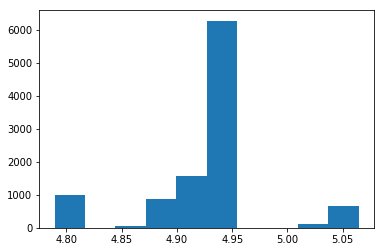

In [90]:
plt.hist(istdList)